# Variance and Bias Detection

These are examples of learning curves used to detect variance and bias (coming soon) in Pytorch models.  The data set and neural network model architecture suffering from variance was suggested by [ChatGPT](https://chat.openai.com/) on 26 Feburary 2023 (using "ChatGPT Feb 13 version").

## Variance Detection

Here's an example of a learning curve for a high variance Pytorch model.

When prompted for a data set and neural network architecture that overfits the data, ChatGPT suggested two hidden layers with 1024 and 512 nodes, along with ReLU activation and dropout.  Training with 500 data points of the [MNIST data set](http://yann.lecun.com/exdb/mnist/) while using 100 epochs for training was also recommended.  Below is the implementation of that model and the resulting learning curve.

The larger number of parameters and extra layers, compared to the example in the [gpu-minibatch.ipynb](https://github.com/AlexGose/learning-curve/blob/main/notebooks/gpu_minibatch.ipynb) notebook, seemed to help induce over-fitting. However, the leveling off of the testing accuracy is clearer after increasing the number of training data points to 800.

In [ ]:
!pip list

In [2]:
# Packages to install on Google Colab
!pip install --upgrade skorch scikit-learn # need scikit-learn v1.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.7/193.7 KB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 107.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


In [3]:
import numpy as np
from sklearn.model_selection import LearningCurveDisplay
from sklearn.metrics import accuracy_score, make_scorer, ConfusionMatrixDisplay
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from skorch import NeuralNetClassifier

In [4]:
train_data = torchvision.datasets.MNIST('.',train=True, download=True)
test_data = torchvision.datasets.MNIST('.',train=False, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [5]:
X_train = train_data.data.view(-1,28*28).detach().numpy().astype(np.float32) / 255
X_test = test_data.data.view(-1,28*28).detach().numpy().astype(np.float32) / 255
X = np.vstack((X_train,X_test))

In [6]:
y_train = train_data.targets.detach().numpy().astype(np.int64)
y_test = test_data.targets.detach().numpy().astype(np.int64)
y = np.concatenate((y_train, y_test))

In [7]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [13]:
class ClassifierModule(nn.Module):
    def __init__(self, num_units1=150, num_units2=100):
        super().__init__()
        self.dense0 = nn.Linear(28*28, num_units1)
        self.nonlin = nn.ReLU()
        self.dense1 = nn.Linear(num_units1, num_units2)
        self.output = nn.Linear(num_units2,10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, X, **kwargs):
        X = self.dense0(X)
        X = self.nonlin(X)
        X = self.dropout(X)
        X = self.dense1(X)
        X = self.nonlin(X)
        X = self.dropout(X)
        X = self.output(X)
        return X

In [23]:
net = NeuralNetClassifier(
    ClassifierModule,
    module__num_units1=1024,
    module__num_units2=512,
    max_epochs=100,
    criterion=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam,
    device=device,
    batch_size=128,
    warm_start=True,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True
)

The learning curves below show a sizeable gap between the testing and training accuracy towards the right of the plot.  Due to the leveling off of both curves, more training data is unlikely to close the gap.  If the desired testing accuracy is higher than 85 percent, for example 90 percent, then this learning curve plot suggests the model has too much variance.

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3047       0.5500        1.8702  0.0072
      2        2.2007       0.4500        4.6869  0.0067
      3        5.5074       0.8500        0.8482  0.0057
      4        0.7637       0.7500        0.7850  0.0066
      5        0.7759       0.7000        0.6639  0.0038
      6        0.5690       0.8500        0.3706  0.0060
      7        0.3565       0.9000        0.1921  0.0060
      8        0.2539       0.9500        0.1313  0.0040
      9        0.2046       1.0000        0.1353  0.0057
     10        0.1482       0.9500        0.1247  0.0057
     11        0.1621       1.0000        0.0211  0.0037
     12        0.0970       1.0000        0.0092  0.0051
     13        0.1329       1.0000        0.0283  0.0053
     14        0.1627       0.9500        0.0788  0.0053
     15        0.0272       0.9500        0.1489  0.0052
     16        0.0883       0.9

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


     25        0.0093       0.9500        0.0644  0.0051
     26        0.0671       1.0000        0.0042  0.0061
     27        0.0213       1.0000        0.0030  0.0054
     28        0.0001       1.0000        0.0109  0.0094
     29        0.0789       1.0000        0.0216  0.0062
     30        0.0025       1.0000        0.0446  0.0075
     31        0.0011       0.9500        0.0766  0.0080
     32        0.0073       0.9500        0.1135  0.0059
     33        0.0584       0.9500        0.1105  0.0064
     34        0.0040       0.9500        0.1419  0.0062
     35        0.0016       0.9500        0.1116  0.0061
     36        0.0327       1.0000        0.0170  0.0053
     37        0.0190       1.0000        0.0014  0.0050
     38        0.0000       1.0000        0.0006  0.0089
     39        0.0000       1.0000        0.0006  0.0054
     40        0.0038       1.0000        0.0017  0.0079
     41        0.0841       1.0000        0.0011  0.0116
     42        0.0404       1.0

Text(0.5, 1.0, 'Learning Curve')

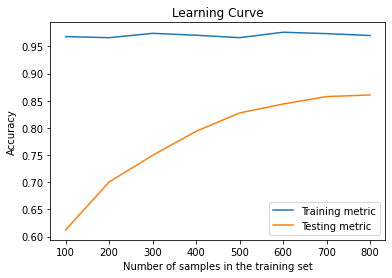

In [25]:
lcd = LearningCurveDisplay.from_estimator(net, X, y, score_type='both', 
                std_display_style=None, score_name='Accuracy', 
    scoring=make_scorer(accuracy_score),
    train_sizes=np.arange(100,801,100))
lcd.ax_.set_title('Learning Curve')